In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submission_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

#создаем новую колонку, преобразуем данные в формат даты

events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
events_data['day'] = events_data.date.dt.date

#добавляем колонку date
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit = 's')
#добавляем колонку day
submission_data['day'] = submission_data.date.dt.date

users_data = events_data.groupby('user_id', as_index= False)\
        .agg({'timestamp': 'max'})\
        .rename({'timestamp':'last_timestamp'}, axis = 'columns')

#создаем параметры тресхолда
now = 1526772811
drop_out_threasold = 2592000

users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threasold

users_scores = submission_data.pivot_table(index='user_id',\
                        columns = 'submission_status',\
                        values = 'step_id',\
                        aggfunc = 'count',\
                        fill_value = 0)\
                        .reset_index()

users_data = users_data.merge(users_scores, on = 'user_id', how = 'outer')

users_data = users_data.fillna(0)

users_invent_data = events_data.pivot_table(index = 'user_id',
                        columns = 'action',
                        values  = 'step_id',
                        aggfunc = 'count',
                        fill_value = 0).reset_index()
users_data = users_data.merge(users_invent_data, how = 'outer')
users_days = events_data.groupby('user_id').day.nunique()
users_days.to_frame().reset_index()
users_data = users_data.merge(users_days, on = 'user_id', how = 'outer')
users_data['passed_corse'] = users_data.passed > 170

- user_id - идентификатор юзера
- last_timestamp - время наступления последнего события в формате unix date
- is_gone_user - признак ушедшего с курса юзера
- correct - кол-во верных решений
- wrong - кол-во попыток (неверных) решений
- discovered - кол-во событий "пользователь перешел на степ"
- passed - кол-во событий "удачное решение практического шага"
- started_attempt - кол-во событий "начало попытки решить шаг"
- viewed - кол-во событий "просмотр шага"
- day - кол-во дней проведенных на курсе
- passed_course - признак завершения юзером курса

In [4]:
users_data.head(5)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [7]:
users_data[users_data.passed_corse].day.median()

20.0

<AxesSubplot:>

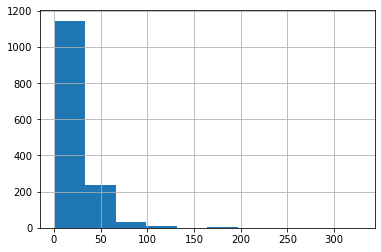

In [10]:
 users_data[users_data.passed_corse].day.hist()

In [11]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


# сохраняем данные когда пользователь впервые сделал активное действие на курсе

In [28]:
events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp': 'min'})\
    .rename({'timestamp' : 'min_timestamp'}, axis=1)

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [19]:
user_min_time = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp': 'min'})\
    .rename({'timestamp' : 'min_timestamp'}, axis=1)

In [22]:
users_data=pd.merge(users_data,user_min_time, how='outer')

In [23]:
users_data.head(5)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [24]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


# сохряняем минимальные timestamp для юзера

In [26]:
event_data_train = pd.DataFrame()

In [34]:
# for user_id in users_data.user_id:
#         min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#         #ставим threshold на 3 дня
#         time_threshold = min_user_time + 3 * 24 * 60 * 60
        
#         #выводим события собятия за 3 дня после первого события 
#         user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_threshold)]
#         break
        
#         event_data_train = event_data_train.append(user_events_data)

Сконкатенируем users_data.user_id и events_data.timestamp

In [40]:
users_data.user_id.map(str)+ ' ' + events_data.timestamp.map(str)

0          1 1434340848
1          2 1434340848
2          3 1434340848
3          5 1434340895
4          7 1434340895
               ...     
3480698             NaN
3480699             NaN
3480700             NaN
3480701             NaN
3480702             NaN
Length: 3480703, dtype: object

In [43]:
events_data['user_time']=events_data.user_id.map(str)+ '_' + events_data.timestamp.map(str)

In [45]:
events_data.shape

(3480703, 7)

In [46]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [47]:
learning_time_threshold = 3 * 24 * 60 * 60
learning_time_threshold

259200

In [50]:
user_learning_time_threshold=user_min_time.user_id.map(str)+ '_' + (user_min_time.min_timestamp+learning_time_threshold).map(str)

In [51]:
user_learning_time_threshold

0            1_1473086664
1            2_1514642564
2            3_1434617676
3            5_1466416009
4            7_1521893860
               ...       
19229    26790_1451743216
19230    26793_1510484231
19231    26794_1495546249
19232    26797_1508684516
19233    26798_1521234963
Length: 19234, dtype: object

In [52]:
user_min_time['user_learning_time_threshold']=user_learning_time_threshold

In [53]:
events_data = events_data.merge(user_min_time[['user_id','user_learning_time_threshold']], how='outer')

In [54]:
events_data.shape

(3480703, 8)

In [55]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [57]:
events_data_train=events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [58]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


## Задача

In [59]:
data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [60]:
data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [61]:
data.groupby('step_id').agg.

In [96]:
data[data['submission_status']=='wrong'].groupby('step_id').agg({'submission_status':'count'}).sort_values(['submission_status'], ascending=False)

,submission_status
step_id,
31978,16084
32031,13373
32202,13002
33481,10300
32075,10003
...,...
33482,707
33681,703
33362,673


## Проверяем количество уникальных дней

In [97]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [99]:
#Добавляем в submissions_data время первого степа
submission_data = submission_data.merge(user_min_time, on='user_id', how='left')
# Время от первого степа до последнего
submission_data['users_time'] = submission_data['timestamp'] - submission_data['min_timestamp']
#Выбираем степы первых трёх дней
submission_data_train = submission_data[submission_data.users_time <= 3*24*60*60]
submission_data_train.groupby('user_id').day.nunique().max()

4

In [115]:
X=submission_data_train.groupby('user_id').day.nunique().reset_index()\
    .rename(columns={'day':'days'})

In [110]:
steps_tried=submission_data_train.groupby('user_id').step_id.nunique().reset_index()\
    .rename(columns={'step_id':'steps_tried'})

In [125]:
steps_tried

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23
...,...,...
8908,26787,3
8909,26790,1
8910,26794,27
8911,26797,2


In [118]:
X=X.merge(steps_tried, on='user_id', how='outer')

In [120]:
X =X.merge(submission_data.pivot_table(index='user_id',\
                        columns = 'submission_status',\
                        values = 'step_id',\
                        aggfunc = 'count',\
                        fill_value = 0)\
                        .reset_index())

In [122]:
X['correct_ratio']=X.correct /(X.correct + X.wrong)

In [124]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,29,23,0.557692
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,77,106,0.420765
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.000000
8909,26790,1,1,1,0,1.000000
8910,26794,3,27,33,9,0.785714
8911,26797,1,2,2,0,1.000000


In [126]:
X =X.merge(events_data_train.pivot_table(index='user_id',\
                        columns = 'action',\
                        values = 'step_id',\
                        aggfunc = 'count',\
                        fill_value = 0)\
                        .reset_index()[['user_id','viewed']], how='outer')

In [127]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,9
1,3,1.0,4.0,29.0,23.0,0.557692,20
2,8,1.0,11.0,9.0,21.0,0.300000,154
3,14,1.0,1.0,0.0,1.0,0.000000,9
4,16,3.0,23.0,77.0,106.0,0.420765,132
...,...,...,...,...,...,...,...
19229,26774,NaN,NaN,NaN,NaN,NaN,1
19230,26781,NaN,NaN,NaN,NaN,NaN,6
19231,26788,NaN,NaN,NaN,NaN,NaN,1
19232,26789,NaN,NaN,NaN,NaN,NaN,2


In [129]:
X=X.fillna(0)

In [131]:
X = X.merge(users_data[['user_id','passed_corse', 'is_gone_user']], how='outer')

In [132]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_corse,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.000000,9,False,True
1,3,1.0,4.0,29.0,23.0,0.557692,20,False,True
2,8,1.0,11.0,9.0,21.0,0.300000,154,False,True
3,14,1.0,1.0,0.0,1.0,0.000000,9,False,True
4,16,3.0,23.0,77.0,106.0,0.420765,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.000000,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.000000,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.000000,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.000000,2,False,True


In [134]:
X=X[~((X.is_gone_user == False) & (X.passed_corse == False))]

In [135]:
y=X.passed_corse.map(int)

In [136]:
X=X.drop(['passed_corse','is_gone_user'],axis=1)

In [139]:
X=X.set_index(X.user_id)
X=X.drop('user_id', axis=1)

In [140]:
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.000000,9
3,1.0,4.0,29.0,23.0,0.557692,20
8,1.0,11.0,9.0,21.0,0.300000,154
14,1.0,1.0,0.0,1.0,0.000000,9
16,3.0,23.0,77.0,106.0,0.420765,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.000000,1
26781,0.0,0.0,0.0,0.0,0.000000,6
26788,0.0,0.0,0.0,0.0,0.000000,1


In [144]:
X.to_csv (r'/Users/mkuzminetc/Stepik-DataScience/X_cotest.csv', header=True)

In [145]:
y.to_csv (r'/Users/mkuzminetc/Stepik-DataScience/y_cotest.csv', header=True)

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np

In [7]:
X=pd.read_csv('/Users/mkuzminetc/Stepik-DataScience/X_cotest.csv')

In [20]:
y=pd.read_csv('/Users/mkuzminetc/Stepik-DataScience/Y_cotest.csv', index=False)

TypeError: read_csv() got an unexpected keyword argument 'index'

In [14]:
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,9
1,3,1.0,4.0,29.0,23.0,0.557692,20
2,8,1.0,11.0,9.0,21.0,0.300000,154
3,14,1.0,1.0,0.0,1.0,0.000000,9
4,16,3.0,23.0,77.0,106.0,0.420765,132
...,...,...,...,...,...,...,...
17980,26774,0.0,0.0,0.0,0.0,0.000000,1
17981,26781,0.0,0.0,0.0,0.0,0.000000,6
17982,26788,0.0,0.0,0.0,0.0,0.000000,1
17983,26789,0.0,0.0,0.0,0.0,0.000000,2


In [23]:
y.drop('Unnamed: 0',axis=1, inplace=True)

In [24]:
y

,passed_corse
0,0
1,0
2,0
3,0
4,1
...,...
17980,0
17981,1
17982,0
17983,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [145]:
y_test.values.ravel().shape

(3597,)

In [143]:
model.predict(X_test).shape

(3597,)

# Функция определения метрик 

In [147]:
from sklearn import metrics

def all_metrics(model, X_test, y_test):
    observations = y_test.values.ravel()
    prediction = model.predict(X_test)

    true_positive = np.logical_and(prediction, observations)
    false_positive = np.logical_and(prediction, np.logical_not(observations))
    true_negative = np.logical_and(np.logical_not(prediction), np.logical_not(observations))
    false_negative = np.logical_and(np.logical_not(prediction), observations)

    tp, fp, tn, fn = (x.sum() for x in (true_positive, false_positive, true_negative, false_negative))
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (recall * precision) / (recall + precision)

    print('True Positive: ', tp)
    print('False Positive: ', fp)
    print('True Negative: ', tn)
    print('False Negative: ', fn)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 score: ', f1_score)
    
    metrics.plot_roc_curve(model, X_test, y_test)
    metrics.plot_precision_recall_curve(model, X_test, y_test)
    metrics.plot_confusion_matrix(model, X_test, y_test)

# Модель LogisticRegressionCV

In [27]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

clf = LogisticRegressionCV(cv=5)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)

clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))
print(clf.coef_)
print(clf.intercept_)
print(cross_val_score(clf,X_train,y_train,cv=4).mean())

/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

0.9844314706700028
[[-2.08494724e-05 -4.70922507e-01 -1.30397071e-02  1.13538769e-01
  -1.80108923e-03 -8.47848584e-01  1.84055878e-03]]
[-4.62962211]


/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

0.9826939115929942


True Positive:  207
False Positive:  31
True Negative:  3330
False Negative:  29
Accuracy:  0.9833194328607172
Precision:  0.8697478991596639
Recall:  0.8771186440677966
F1 score:  0.8734177215189872


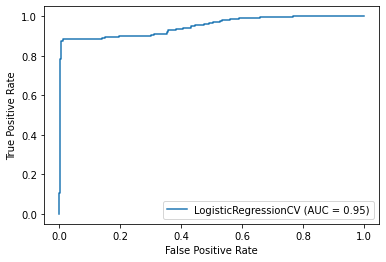

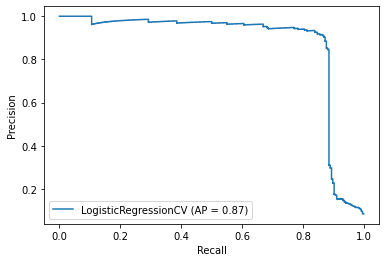

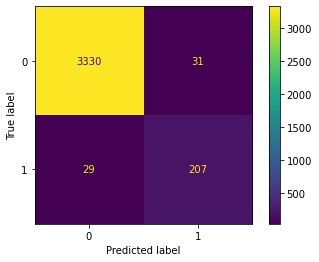

In [150]:
all_metrics(clf, X_test, y_test)

# Модель DecisionTreeClassifier

In [37]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

dt = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': range(3,6), 'max_leaf_nodes':range(6,15), 'min_samples_leaf': range(1,4),'min_samples_split':range(2,5)}
grid_search_cv_clf = GridSearchCV(dt,parameters,cv=4)
grid_search_cv_clf.fit(X_train,y_train)

best_clf = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_train,y_train,cv=4).mean())

best_clf.score(X_test,y_test)
#метрики
y_pred=best_clf.predict(X_test)
precision_score(y_test, y_pred)
recall_score(y_test, y_pred)
f1_score(y_test, y_pred)

/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_se

{'max_depth': 4, 'max_leaf_nodes': 8, 'min_samples_leaf': 3, 'min_samples_split': 2} 0.924798443147067


0.9023861171366594

True Positive:  208
False Positive:  17
True Negative:  3344
False Negative:  28
Accuracy:  0.987489574645538
Precision:  0.9244444444444444
Recall:  0.8813559322033898
F1 score:  0.9023861171366594


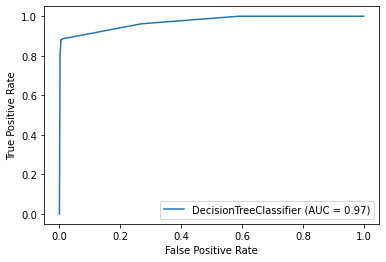

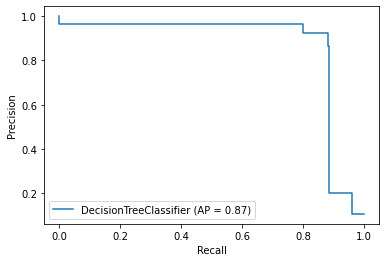

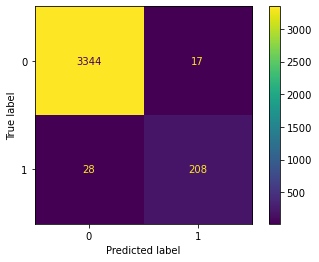

In [148]:
all_metrics(best_clf, X_test, y_test)

# Модель KNeighborsClassifier

In [112]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(15,25), 'leaf_size':range(1,7)}
grid_search_cv_clf = GridSearchCV(knn,parameters,cv=4,n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_train,y_train,cv=4).mean())

/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-112-71a6fcff16c5>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(X_train, y_train)
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mkuzminetc/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d 

{'leaf_size': 1, 'n_neighbors': 15} 0.924798443147067


# Функция Метрик Джованни

In [129]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

def percentile_fn(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def metrics(clf, expected, predictions, predictors, threshold=0.5, agg_column=None, percentile=None):
    if agg_column is not None:
        aggs = {
            'expected': 'max',
            'preds': percentile_fn(percentile) if percentile is not None else 'max'
        }
        grouped_df = pd.DataFrame({'expected': expected, 'preds': predictions, 'agg_column': agg_column}).groupby('agg_column').agg(aggs)
        preds = (grouped_df['preds'] >= threshold).astype(int)
        expected = grouped_df['expected']
    else:
        preds = (predictions >= threshold).astype(int)
        
    tn, fp, fn, tp = confusion_matrix(expected, preds).ravel()

    try:
        hit_rate = (int(tp)/(int(fp)+int(tp)))
    except:
        hit_rate = 0
    try:
        catch_rate = (int(tp)/(int(fn)+int(tp)))
    except:
        catch_rate = 0
    roc_auc = (roc_auc_score(expected, preds))
    prc_auc = (average_precision_score(expected, preds))
    return tn, fp, fn, tp, hit_rate, catch_rate, roc_auc, prc_auc

def calculate_metrics(clf, Y, preds, predictors, thresholds=[0.5, 0.4, 0.3, 0.2, 0.1], agg_column=None, percentile=None):
    if clf is not None:
        feature_importances = None
        try:
            feature_importances = sorted(zip(predictors, clf.feature_importances_), key=lambda x: x[1], reverse=True)
            print('Feature importances')
            pprint(feature_importances)
        except Exception as e:
            print(e)
    results = []
    for i in thresholds:
        tn, fp, fn, tp, hit_rate, catch_rate, roc_auc, prc_auc = metrics(
            clf=clf,
            expected=Y,
            predictions=preds,
            predictors=predictors,
            threshold=i,
            agg_column=agg_column,
            percentile=percentile
        )
        results.append({
            'Threshold': i,
            'True Negatives': tn,
            'False Positives': fp,
            'False Negatives': fn,
            'True Positives': tp,
            'Precision': "{:.2%}".format(hit_rate),
            'Recall': "{:.2%}".format(catch_rate),
            'ROC AUC': "{:.2%}".format(roc_auc),
            'PRC AUC': "{:.2%}".format(prc_auc),
            'Volume': tp + fp,
        })
    results_df = pd.DataFrame(results)[['Threshold','True Negatives','False Positives','False Negatives','True Positives','Volume','Precision','Recall','ROC AUC','PRC AUC']]
    return results_df

In [136]:
thresholds=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1]
calculate_metrics(clf=model,
                  Y=y_test,
                  preds=model.predict(X_test),
                  predictors=[],
                 thresholds=thresholds,
                 agg_column=None, percentile=None)

'KNeighborsClassifier' object has no attribute 'feature_importances_'


,Threshold,True Negatives,False Positives,False Negatives,True Positives,Volume,Precision,Recall,ROC AUC,PRC AUC
0,0.90,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%
1,0.80,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%
2,0.70,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%
3,0.60,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%
4,0.50,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%
5,0.40,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%
6,0.30,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%
7,0.28,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%
8,0.26,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%
9,0.24,3348,13,197,39,52,75.00%,16.53%,58.07%,17.87%


True Positive:  39
False Positive:  13
True Negative:  3348
False Negative:  197
Accuracy:  0.9416180150125104
Precision:  0.75
Recall:  0.1652542372881356
F1 score:  0.2708333333333333


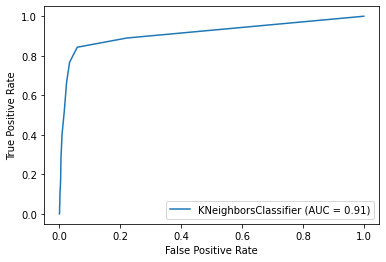

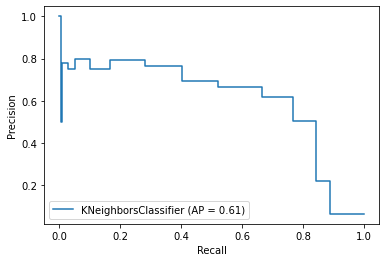

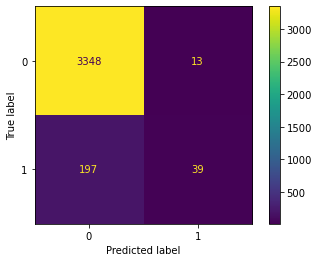

In [149]:
all_metrics(model, X_test, y_test)